<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Extreme-Simplicity-Bias-can-hurt-Generalization" data-toc-modified-id="Extreme-Simplicity-Bias-can-hurt-Generalization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Extreme Simplicity Bias can hurt Generalization</a></span><ul class="toc-item"><li><span><a href="#FCNs--trained-on-$\mathtt{\hat{L}MS-7}$-attain-95%-(suboptimal)-test-accuracy" data-toc-modified-id="FCNs--trained-on-$\mathtt{\hat{L}MS-7}$-attain-95%-(suboptimal)-test-accuracy-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>FCNs  trained on $\mathtt{\hat{L}MS-7}$ attain 95% (suboptimal) test accuracy</a></span></li><li><span><a href="#FCNs--trained-on-$\mathtt{MS-7}$-attain-100%-test-accuracy" data-toc-modified-id="FCNs--trained-on-$\mathtt{MS-7}$-attain-100%-test-accuracy-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>FCNs  trained on $\mathtt{MS-7}$ attain 100% test accuracy</a></span></li></ul></li></ul></div>

# Extreme Simplicity Bias can hurt Generalization

In this notebook, we reproduce our findings presented in Section 5 of the paper, where we show that, contrary to conventional wisdom, extreme SB can result in suboptimal generalization of SGD-trained models on the same data distribution as well. This is because exclusive reliance on the simplest feature can persist even when *every complex feature has significantly greater predictive power than the simplest feature*.
We verify this phenomenon on the $\mathtt{\hat{L}MS-7}$ dataset using fully-connected neural networks (FCNs). Please refer to Appendix D.1 of the paper for details about the experiment setup.

In [49]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from imports import *

DEVICE_ID = 0 # GPU_ID or None (CPU)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## FCNs  trained on $\mathtt{\hat{L}MS-7}$ attain 95% (suboptimal) test accuracy

FCNs of depth {1,2} and width {100, 200, 300} that are trained on $\mathtt{\hat{L}MS-7}$ using SGD attain suboptimal generalization (95% standard test accuracy) by relying on the noisy linear coordinate even though there exist multiple 7-slab coordinates that have 100% predictive power. 

In [50]:
# data.keys() #dict_keys(['X', 'Y', 'w', 'tr_dl', 'te_dl', 'N', 'W'])
for sample in data['te_dl']:
    print(sample[0].shape)
    break

torch.Size([256, 50])


### settings
```py
# 3 dim, 1 linear, 1 7 slab, 1 uniform -> no SB (zigzag boundary)
c = config =  {
    'num_train': 40_000, # training dataset size
    'dim': 3, # input dimension, originally 50
    'lin_margin': 0.1, # linear margin
    'slab_margin': 0.1, # slab margin,
    'same_margin': True, # keep same margin
    'random_transform': True, # apply random transform
    'width': 1, # data width
    'num_lin': 1, # number of linear components
    'num_slabs': 0, #. number of 5slabs
    'num_slabs7': 1, # number of 7slabs, originally 49
    'num_slabs3': 0, # number of 3slabs
    'num_gauss' : 0,
    'bs': 256, # batch size
    'corrupt_lin': 0.1, # p_noise (10% default)
    'corrupt_lin_margin': True, # noise model
    'corrupt_slab': 0.0, # slab corruption
    'num_test': 10_000, # test dataset size
    'hdim': 300, # model width
    'hl': 2, # model depth
    'mtype': 'fcn', # model architecture
    'device': gu.get_device(DEVICE_ID), # GPU device
    'lr': 0.1, # step size
    'weight_decay': 5e-4, # weight decay,
    'momentum': 0.9 # momentum
}
```

Text(0.5, 0.98, 'LSN')

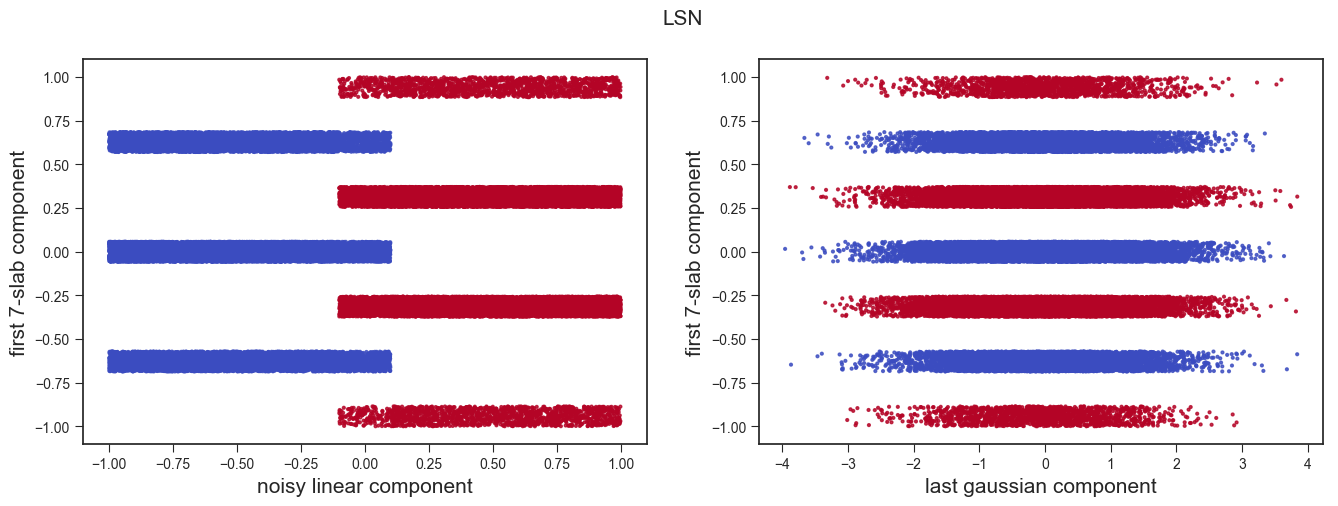

In [99]:
"""
Note: our results on models trained on LMS-7 using SGD with the above data
hyperparameters are robust to a wide range of SGD hyperparameters and 
for FCNs of depth {1,2} and width {100, 200, 300}. Training with some SGD
hyperparamters take longer (or do not) converge so for now, we have picked
SGD hyparameters that converge (w.r.t. training performance) fairly quickly
You can try changing the SGD hyperparmaters and re-running this notebook 
"""

c = config =  {
    'num_train': 40_000, # training dataset size
    'dim': 9, # input dimension, originally 50
    'lin_margin': 0.1, # linear margin
    'slab_margin': 0.1, # slab margin,
    'same_margin': True, # keep same margin
    'random_transform': True, # apply random transform
    'width': 1, # data width
    'num_lin': 1, # number of linear components
    'num_slabs': 0, #. number of 5slabs
    'num_slabs7': 1, # number of 7slabs, originally 49
    'num_slabs3': 0, # number of 3slabs
    'num_gauss' : 7, # number of gaussian noise coordinates
    'bs': 256, # batch size
    'corrupt_lin': 0.1, # p_noise (10% default)
    'corrupt_lin_margin': True, # noise model
    'corrupt_slab': 0.0, # slab corruption
    'num_test': 10_000, # test dataset size
    'hdim': 300, # model width
    'hl': 2, # model depth
    'mtype': 'fcn', # model architecture
    'device': gu.get_device(DEVICE_ID), # GPU device
    'lr': 0.1, # step size
    'weight_decay': 5e-4, # weight decay,
    'momentum': 0.9 # momentum
}

data = get_data(**c)

# visualize noisy LMS
fig, (ax, ax_) = plt.subplots(1,2,figsize=(16, 5))
W = data['W']
X, Y = data['X'], data['Y']
X = X.numpy().dot(W.T)
ax.scatter(X[:,0], X[:,1], c=Y, cmap='coolwarm', s=4, alpha=0.8) # first coord is linear, second is slab
ax.set_xlabel('noisy linear component', fontsize=15)
ax.set_ylabel('first 7-slab component', fontsize=15)

# ax_.scatter(X[:,2], X[:,1], c=Y, cmap='coolwarm', s=4, alpha=0.8) # first coord is linear, second is slab
# ax_.set_xlabel('second 7-slab component', fontsize=15)
# ax_.set_ylabel('first 7-slab component', fontsize=15)
# fig.suptitle('Noisy LMS', fontsize=15)


ax_.scatter(X[:,-1], X[:,1], c=Y, cmap='coolwarm', s=4, alpha=0.8) # first coord is linear, second is slab
ax_.set_xlabel('last gaussian component', fontsize=15)
ax_.set_ylabel('first 7-slab component', fontsize=15)
fig.suptitle('LSN', fontsize=15)

In [100]:
# training FCN on noisy LMS data 
model = synth_models.get_fcn(idim=c['dim'], hdim=c['hdim'], odim=2, hl=c['hl']).to(c['device'])
opt = optim.SGD(model.parameters(), lr=c['lr'], momentum=c['momentum'], weight_decay=c['weight_decay'])

stats = utils.fit_model(model, F.cross_entropy, opt, data['tr_dl'], 
                        data['te_dl'], gap=2_000, device=c['device'],
                        epsilon=0.005, patience_updates=1)

# note: if it has almost converged, you can interrupt and enter Q to 
# stop training or interrupt and change the LR to meet the stopping criterion

accuracy/loss measured every 2000 updates
update_print_gap: 2000, epss: 0.005, bs: 256, device: cpu
#updates, train acc, test acc, train loss
0 0.5031 0.5043 0.6949
2000 0.9532 0.9505 0.0921
4000 0.9526 0.9498 0.0819
6000 0.9529 0.9482 0.0824
8000 0.9521 0.9498 0.0809
10000 0.9528 0.9484 0.0818
12000 0.9507 0.9487 0.0871
14000 0.9522 0.9517 0.0827
16000 0.9524 0.9510 0.0813
18000 0.9511 0.9492 0.0890
20000 0.9513 0.9493 0.0825
22000 0.9520 0.9516 0.0798
24000 0.9522 0.9509 0.0822
26000 0.9526 0.9519 0.0813
28000 0.9524 0.9499 0.0799
30000 0.9509 0.9486 0.0834
32000 0.9524 0.9484 0.0874
34000 0.9529 0.9485 0.0819
36000 0.9518 0.9505 0.0808
38000 0.9518 0.9504 0.0813
40000 0.9527 0.9509 0.0810
42000 0.9523 0.9497 0.0808
44000 0.9519 0.9503 0.0823
46000 0.9521 0.9496 0.0812
48000 0.9511 0.9509 0.0809
50000 0.9494 0.9479 0.0831
52000 0.9527 0.9502 0.0820
54000 0.9508 0.9504 0.0829
56000 0.9518 0.9503 0.0815
58000 0.9511 0.9493 0.0819
60000 0.9507 0.9485 0.0826
62000 0.9517 0.9498 0.0808
64

Coordinate-wise randomized accuracies:
0:0.497 1:0.949 5:0.949 2:0.949 6:0.949 7:0.950 3:0.950 4:0.950 8:0.950 



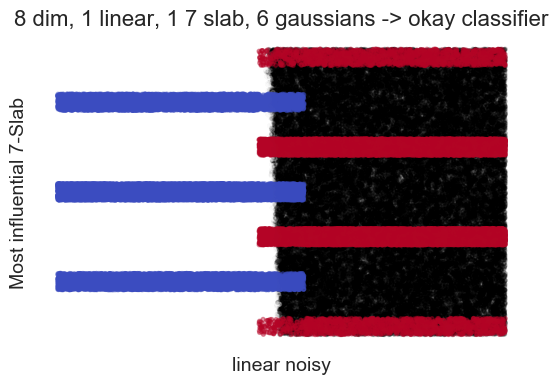

In [101]:
"""
Two-dimensional projection of the model's decision boundary
onto the two most influential coordinates (measured using randomized AUC)
"""
print ("Coordinate-wise randomized accuracies:")
ax = lms_utils.visualize_boundary(model, data, 0, 1, 10, ax=None, width=1, unif_k=True, k=100_000, print_info=True)
utils.update_ax(ax, '8 dim, 1 linear, 1 7 slab, 6 gaussians -> okay classifier', 'linear noisy', 'Most influential 7-Slab', 
                title_fs=16, label_fs=14, legend_loc=False)
sns.despine(ax=ax, bottom=True, left=True); ax.set_xticks([]); ax.set_yticks([])
None


In [46]:
# Pick model that performs best on validation data
model = stats['best_model'][-1].to(c['device'])

# Standard and randomized accuracies of the trained model
s_dl = lms_utils.get_randomized_loader(data['te_dl'], data['W'], [0])
sc_dl = lms_utils.get_randomized_loader(data['te_dl'], data['W'], list(range(1, c['dim'])))

acc_func = utils.compute_loss_and_accuracy_from_dl
train_accuracy, _ = acc_func(data['tr_dl'], model, F.cross_entropy, device=c['device'])
test_accuracy, _ = acc_func(data['te_dl'], model, F.cross_entropy, device=c['device'])
lin_accuracy, _ = acc_func(s_dl, model, F.cross_entropy, device=c['device'])
slab_accuracy, _ = acc_func(sc_dl, model, F.cross_entropy, device=c['device'])

print ('Train Accuracy: {:.3f}'.format(train_accuracy.item()))
print ('Test Accuracy: {:.3f}'.format(test_accuracy.item()))
print ('Linear (S) Randomized Accuracy: {:.3f}'.format(lin_accuracy.item()))
print ('Slab (S^c) Randomzied Accuracy: {:.3f}'.format(slab_accuracy.item()))

Train Accuracy: 0.974
Test Accuracy: 0.944
Linear (S) Randomized Accuracy: 0.509
Slab (S^c) Randomzied Accuracy: 0.947


## FCNs  trained on $\mathtt{MS-7}$ attain 100% test accuracy

FCNs of depth {1,2} and width {100, 200, 300} that are trained on $\mathtt{MS-7}$ using SGD attain 100% standard accuracy. Recall that $\mathtt{MS-7}$ data comprises of $50$ $7$-slab coordinates, all of which have $100\%$ predictive power. Compared to $\mathtt{MS-7}$, $\mathtt{\hat{L}MS-7}$ data has $49$ $7$-slab coordinates and a noisy linear coordinate ($10\%$ noise in linear coordinate). In this section, we show that replacing the linear component from the $\mathtt{\hat{L}MS-7}$ (i.e. training on $\mathtt{MS-7}$ data) results in $100\%$ generalization with the same sample size. 

Text(0.5, 0.98, '$\\mathtt{MS-7}$')

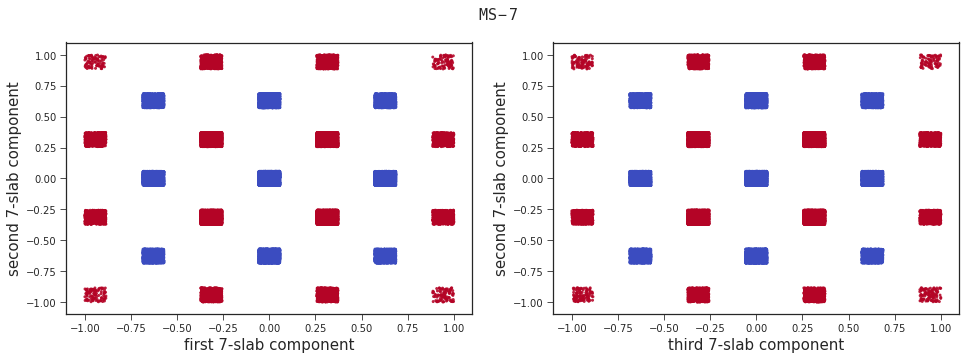

In [5]:
c = config =  {
    'num_train': 40_000, # training dataset size
    'dim': 50, # input dimension
    'lin_margin': 0.1, # linear margin
    'slab_margin': 0.1, # slab margin,
    'same_margin': True, # keep same margin
    'random_transform': True, # apply random transform
    'width': 1, # data width
    'num_lin': 0, # number of linear components
    'num_slabs': 0, #. number of 5slabs
    'num_slabs7': 50, # number of 7slabs
    'num_slabs3': 0, # number of 3slabs
    'bs': 256, # batch size
    'corrupt_lin': 0.1, # p_noise (10% default)
    'corrupt_lin_margin': True, # noise model
    'corrupt_slab': 0.0, # slab corruption
    'num_test': 10_000, # test dataset size
    'hdim': 300, # model width
    'hl': 2, # model depth
    'mtype': 'fcn', # model architecture
    'device': gu.get_device(DEVICE_ID), # GPU device
    'lr': 0.3, # step size
    'weight_decay': 5e-4, # weight decay,
    'momentum': 0.9 # momentum
}

data = get_data(**c)

# visualize noisy LMS
fig, (ax, ax_) = plt.subplots(1,2,figsize=(16, 5))
W = data['W']
X, Y = data['X'], data['Y']
X = X.numpy().dot(W.T)
ax.scatter(X[:,0], X[:,1], c=Y, cmap='coolwarm', s=4, alpha=0.8) # first coord is linear, second is slab
ax.set_xlabel('first 7-slab component', fontsize=15)
ax.set_ylabel('second 7-slab component', fontsize=15)

ax_.scatter(X[:,2], X[:,1], c=Y, cmap='coolwarm', s=4, alpha=0.8) # first coord is linear, second is slab
ax_.set_xlabel('third 7-slab component', fontsize=15)
ax_.set_ylabel('second 7-slab component', fontsize=15)
fig.suptitle(r'$\mathtt{MS-7}$', fontsize=15)

In [6]:
# training FCN on MS-7 data 
model = synth_models.get_fcn(idim=c['dim'], hdim=c['hdim'], odim=2, hl=c['hl']).to(c['device'])
opt = optim.SGD(model.parameters(), lr=c['lr'], momentum=c['momentum'], weight_decay=c['weight_decay'])

stats = utils.fit_model(model, F.cross_entropy, opt, data['tr_dl'], 
                        data['te_dl'], gap=2000, device=c['device'],
                        epsilon=0.005, patience_updates=1000)

accuracy/loss measured every 2000 updates
update_print_gap: 2000, epss: 0.005, bs: 256, device: cuda:0
#updates, train acc, test acc, train loss
0 0.4946 0.5012 0.6950
2000 0.5646 0.5004 0.6848
4000 0.6161 0.5167 0.6574
6000 0.6474 0.5294 0.6260
8000 1.0000 1.0000 0.0049
converged after 50 epochs in 0.0m 29.610891s, gap: 0.0
init-ing patience (1000 updates)
9000 1.0000 1.0000 0.0045


In [7]:
# Pick model that performs best on validation data
model = stats['best_model'][-1].to(c['device'])

# Standard and randomized accuracies of the model train on MS-7
acc_func = utils.compute_loss_and_accuracy_from_dl
train_accuracy, _ = acc_func(data['tr_dl'], model, F.cross_entropy, device=c['device'])
test_accuracy, _ = acc_func(data['te_dl'], model, F.cross_entropy, device=c['device'])

print ('Train Accuracy: {:.3f}'.format(train_accuracy.item()))
print ('Test Accuracy: {:.3f}'.format(test_accuracy.item()))

Train Accuracy: 1.000
Test Accuracy: 1.000


- which coordinate can I fit the gaussian noise
- are there going to be any empty coordinates